# 2D pattern recognition

### Imports

In [283]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

## Automata for pattern recognition

#### State structure

In [ ]:
class AutomataState:
    def __init__(self, number, letter):
        self.transitions = {}
        self.letter = letter
        self.number = number
        self.fail = None

## Automata builder

In [ ]:
def two_d_pattern_automata(pattern_arr):
    state_number = 0
    start = AutomataState(state_number, None)
    state_number += 1
    
    #### Creating all states ####
    for pattern in pattern_arr.T:
        state = start
        for letter in pattern:
            if letter not in state.transitions:
                state.transitions[letter] = AutomataState(state_number, letter)
                state_number += 1
            state = state.transitions[letter]
    
    #### Computing fail nodes ####
    queue = list(start.transitions.values())
    for state in queue:
        state.fail = start
    while queue:
        state = queue.pop(0)
        for next_state in state.transitions.values():
            queue.append(next_state)
            
            fail_state = state.fail
            while fail_state is not None and next_state.letter not in fail_state.transitions:
                fail_state = fail_state.fail
            if fail_state is None:
                next_state.fail = start
            else:
                next_state.fail = fail_state.transitions[next_state.letter]
    
    return start

In [ ]:
def columns_automata_pass(start_state, data_to_match):
    column_states = np.zeros(data_to_match.shape, dtype=np.int32)
    for col in range(data_to_match.shape[1]):
        state = start_state
        for row in range(data_to_match.shape[0]):
            while state is not None and data_to_match[row, col] not in state.transitions:
                state = state.fail
            if state is None:
                state = start_state
            else:
                state = state.transitions[data_to_match[row, col]]
            column_states[row, col] = state.number
    return column_states

In [ ]:
def str_lines_to_ndarray(lines):
    return np.array(list(map(list, lines)))

In [ ]:
data = str_lines_to_ndarray(["abbb", "cdab","cdcd"])
aut = two_d_pattern_automata(np.array([list("ac"), list("bd")]))
print(data)

In [ ]:
test_text = """abbbdsa
cdab
cdcddd"""

test_pattern = """ab
cd"""

print(columns_automata_pass(aut, data))
print(columns_automata_pass(aut, str_lines_to_ndarray(["ac", "bd"]).T))

In [ ]:
def kmp_matching(text, pattern, pi = None):
    if pi is None:
        pi = prefix_function(pattern)
    patt_len = len(pattern)
    q = 0
    correct_s = []
    for i in range(0, len(text)):
        while(q > 0 and pattern[q] != text[i]):
            q = pi[q-1]
        if(pattern[q] == text[i]):
            q = q + 1
        if(q == len(pattern)):
            correct_s.append(i - patt_len + 1)
            q = pi[q-1]
    return correct_s
            
def prefix_function(pattern):
    pi = [0]
    k = 0
    for q in range(1, len(pattern)):
        while k > 0 and pattern[k] != pattern[q]:
            k = pi[k-1]
        if pattern[k] == pattern[q]:
            k = k + 1
        pi.append(k)
    return pi

In [ ]:
def prepare_text_to_match(text, pattern):
    lines = text.split("\n")
    desirable_len = max(map(len, lines))
    filler = '!'
    while filler in text or filler in pattern:
        filler = chr(ord(filler) + 1)
    for row in range(len(lines)):
        lines[row] = lines[row] + (desirable_len - len(lines[row])) * filler
    return str_lines_to_ndarray(lines)
    
def match_2d_pattern(text, pattern):
    automata = two_d_pattern_automata(pattern)
    states = columns_automata_pass(automata, text)
    states_pattern = columns_automata_pass(automata, pattern)[-1]
    pattern_height = pattern.shape[0]
    occurences = []
    for i, row in enumerate(states):
        for j in kmp_matching(row, states_pattern):
            occurences.append((i-pattern_height+1, j))
    return occurences

In [ ]:
prepared_text = prepare_text_to_match(test_text, test_pattern)
prepared_pattern = prepare_text_to_match(test_pattern, test_pattern)
match_2d_pattern(prepared_text, prepared_pattern)

In [ ]:
haystack_text = open("haystack.txt", 'r').read()
haystack_text_np = prepare_text_to_match(haystack_text, "")
letters = set(haystack_text)
letters.remove('\n')

In [ ]:
for letter in sorted(letters):
    print(f"{letter}: {len(match_2d_pattern(haystack_text_np, np.array([[letter],[letter]])))}")

In [ ]:
print(match_2d_pattern(haystack_text_np, prepare_text_to_match("th\nth", "")))
print(match_2d_pattern(haystack_text_np, prepare_text_to_match("t h\nt h", "")))

In [313]:
haystack_img = cv2.threshold(cv2.imread("haystack.png", cv2.IMREAD_GRAYSCALE), 127, 255, cv2.THRESH_BINARY)[-1]

In [314]:
def check_img_match(full_img, pattern_img, full_text, pattern_text):
    img_match = len(match_2d_pattern(full_img, pattern_img))
    pattern_match = len(kmp_matching(full_text, pattern_text))
    print(f"Patterns matched in image: {img_match}")
    print(f"Patterns matched in text: {pattern_match}")

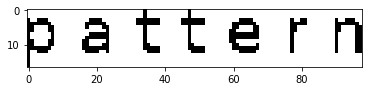

In [315]:
test_pattern_img = haystack_img[474:491,185:283]

plt.imshow(255-pattern_img, cmap='Greys')

In [316]:
check_img_match(haystack_img, test_pattern_img, haystack_text, "p a t t e r n")

Patterns matched in image: 5
Patterns matched in text: 5


In [318]:
letters_postions = {
    'e': ((59, 69), (90, 99)),
    'a': ((103, 113), (56, 64))
}

Patterns matched in image: 583
Patterns matched in text: 583
Patterns matched in image: 397
Patterns matched in text: 397


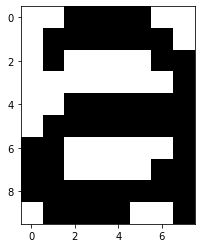

In [320]:
for letter, ((y0, y1), (x0, x1)) in letters_postions.items():
    letter_img = haystack_img[y0:y1, x0:x1]
    plt.imshow(255-letter_img, cmap='Greys')
    check_img_match(haystack_img, letter_img, haystack_text, letter)

In [ ]:
print(len(match_2d_pattern(haystack_img, e_img)))
print(len(np.argwhere(haystack_text_np == 'e')))

In [ ]:
a_img = haystack_img[103:113,56:64]
plt.imshow(255-a_img, cmap='Greys')

In [ ]:
print(len(match_2d_pattern(haystack_img, a_img)))
print(len(np.argwhere(haystack_text_np == 'a')))